<a href="https://colab.research.google.com/github/MinyoungHer/Pytorch-study/blob/main/ViT_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Getting setup
`going_modular` 와 `torchinfo` 다운로드

In [2]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1])>=12
  assert int(torch.__version__.split(".")[2])>=13
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torch.__version__}")

except:
  print(f"[INFO] torch/torchvision version not as required, installing nightly versions.")
  !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.py
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torch.__version__}")

[INFO] torch/torchvision version not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.py
torch version: 2.0.1+cu118
torchvision version: 2.0.1+cu118


* 각종 모듈들 다운로드
* `helper_functions`모듈 다운로드

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo.. installing it")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo.. installing it
[INFO] Couldn't find going_modular or helper_functions scripts... downloading
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3881, done.
remote: Counting objects: 100% (1051/1051), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 3881 (delta 979), reused 943 (delta 932), pack-reused 2830
Receiving objects: 100% (3881/3881), 647.98 MiB | 22.62 MiB/s, done.
Resolving deltas: 100% (2272/2272), done.
Updating files: 100% (248/248), done.


* GPU

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get data
* 피자, 스테이크, 스시 이미지 데이터 셋을 다운로드한다.
* 해당 데이터 셋은 mrdbourke씨의 github에서 다운받을 수 있다.

In [5]:
image_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                         destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

* training, test 디렉토리를 생성한다.

In [6]:
train_dir=image_path/"train"
test_dir=image_path/"test"

#2. Create Datsets and DataLoaders
* 데이터를 불러왔다면, 이를 `dataloader`로 변경하는 과정이 필요하다.
* 그 전에 이미지 사이즈를 224*224로 하는 텐서로 바꾸는 manual_transforms를 설정한다.

In [7]:
IMG_SIZE=224

manual_transforms=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


* 배치 사이즈를 32로 하는 데이터 로더를 생성시킨다.
* 각각의 train, test 디렉토리로 부터 데이터 로더를 생성한다.

In [8]:
BATCH_SIZE=1024

train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a316ae5ff40>,
 ['pizza', 'steak', 'sushi'])

* train dataloader에서 첫번째 배치의 데이터의 사이즈를 확인해본다.
* 이미지는 3x224x224사이즈로, 레이블은 1로 저장되어 있는 것을 확인할 수 있다.


In [9]:
image_batch, label_batch=next(iter(train_dataloader))
image, label=image_batch[1], label_batch[1]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

* 첫 번째 배치의 이미지를 불러오면 스시인 것을 확인할 수 있다.

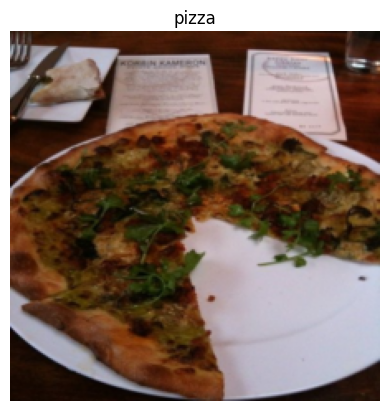

In [10]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

* 그 다음으로는 (Batch_size, Color_channel, Height, Width) 형태의 난수를 발생시킨다.

In [11]:
rand_image_tensor=torch.randn(32,3,224,224)
rand_image_tensor.shape

torch.Size([32, 3, 224, 224])

#3. Replicating the ViT paper: an overview

## 3.1 Inputs and outputs, layers and blocks
* ViT는 딥러닝 아키텍쳐이다. 이는 layers로 구성된다.
* layer의 구성은 block이다.
* 이러한 block을 차례대로 쌓는 과정이 전체적인 딥러닝 아키텍처에 해당한다.


##3.2 Exploring the Four Equations
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

* \begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\end{aligned}
*   x_input=[class_token, image_patch_1, image_patch_2, ...] + [class_token_position, image_patch_1_position, ...]

* \begin{aligned}
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\end{aligned}

* 이 식은 1 부터 L까지의 모든 레이어에 대해서 Multi-Head Attention Layer를 통과한다는 의미이며 잔여학습을 실행한다는 의미이다.

* \begin{aligned}
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}

* 다음 식은 인풋이 linear layer를 통과한 후 Multi layers perceptron을 통과하는 과정을 나타낸다. 또한 잔여학습 실행까지 나타내었다.

* \begin{aligned}
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
* 마지막 L레이어에 대해서는 선형 레이어를 통과한다.

#4. Eqauation 1: Split data into patches and creating the class, position and patch embedding

* D는 패치 임베딩의 크기를 나타낸다.
* 이미지 데이터는 2D로 HxWxC사이즈로 시작한다.
* 여기서 (HxW)는 본래의 이미지의 해상도를 나타낸다.
* 반면 C는 channel의 수를 나타낸다.

* 이러한 이미지 데이터는 flattened 2D patch로 변환시켜야 한다. 사이즈는 $N*(P^2*C)$
* 여기서 (P,P)는 이미지 패치의 해상도를 나타낸다.
* 여기서 N=HW/P^2는 트랜스포머의 길이를 나타내며 패치의 개수를 나타낸다.

## 4.1 Calculating patch embedding input and output shapes by hand
* 이러한 ViT의 인풋 데이터에 대한 변형을 한 번 실습해보도록 하겠다.

In [12]:
height=224
width=224
color_channels=3
patch_size=16

number_of_patches=int((height*width)/patch_size**2)
number_of_patches

196

* 먼저 224x224x3크기의 이미지 데이터를 가정하고 패치 사이즈를 16으로 한다면, 패치의 개수 N은 196이 될 것이다.

In [13]:
embedding_layer_input_shape=(height, width, color_channels)
embedding_layer_output_shape=(number_of_patches, patch_size**2*color_channels)
print(f"Input shape: {embedding_layer_input_shape}")
print(f"Output shape: {embedding_layer_output_shape}")

Input shape: (224, 224, 3)
Output shape: (196, 768)


* Input shape이 2D 이미지의 HxWxC의 형태였고 output shape이 Nx(P^2*c)의 형태였다는 것을 고려본다.
* 위의 예시와 같이 input 형태는 224x224x3이 되고 output shape은 196x768의 형태가 된다.

## 4.2 Turning a single image into patches
* 다음으로 실제 하나의 이미지 예시를 가지고 패치 임베딩을 실시해보도록 하겠다.

(-0.5, 223.5, 223.5, -0.5)

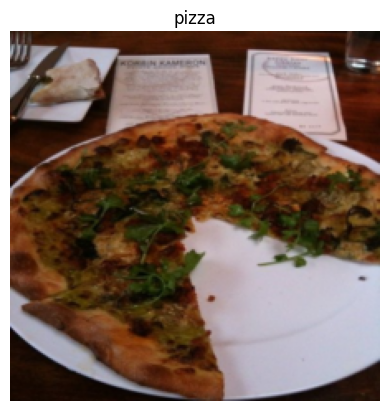

In [14]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

* 먼저 가장 위의 행의 패치 픽셀들을 고려해보겠다.

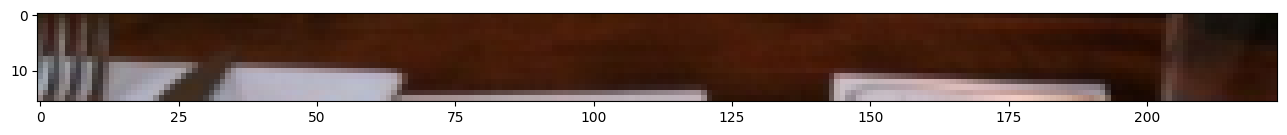

In [15]:
image_permuted=image.permute(1,2,0)

patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
 Patch size: 16 pixels x 16 pixels


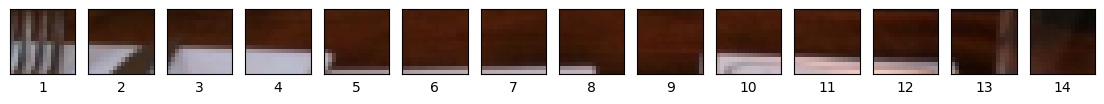

In [16]:
img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0
print(f"Number of patches per row: {num_patches}\n Patch size: {patch_size} pixels x {patch_size} pixels")

fig, axs=plt.subplots(nrows=1,
                      ncols=img_size // patch_size,
                      figsize=(num_patches, num_patches),
                      sharex=True,
                      sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

* 패치들의 크기에 따라 14개의 패치들로 나눠진 것을 확인할 수 있다.
* 이제 총 그림에 대해서 패치들로 나눠보도록 하겠다.

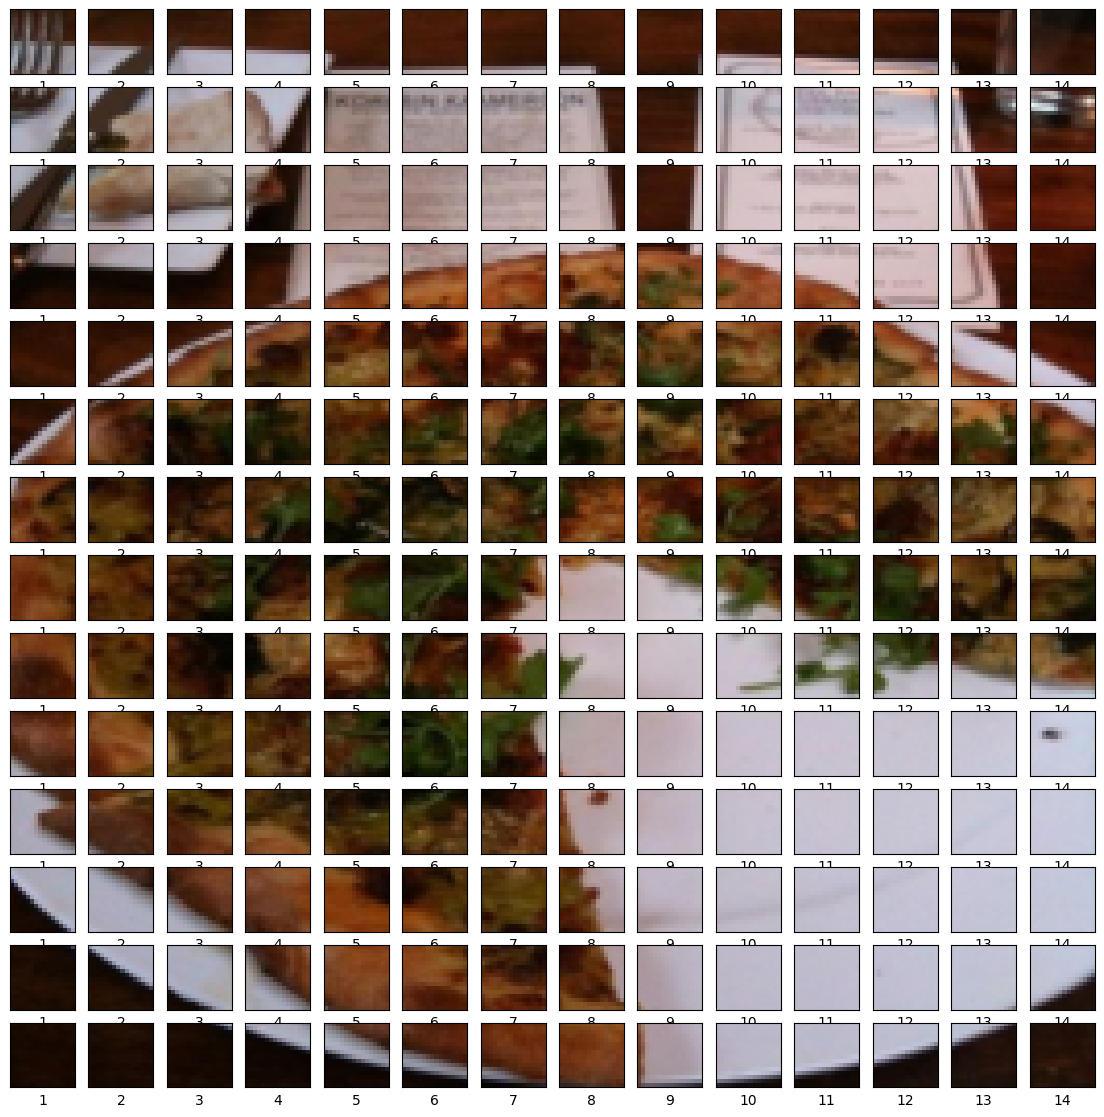

In [17]:
img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0

fig, axs=plt.subplots(nrows=int(num_patches),
                      ncols=int(num_patches),
                      figsize=(num_patches, num_patches),
                      sharex=True,
                      sharey=True)
for i, patch_height in enumerate(range(0,img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                   patch_width:patch_width+patch_size,
                                   :])
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])


 Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch_size: 16 pixels x 16 pixels


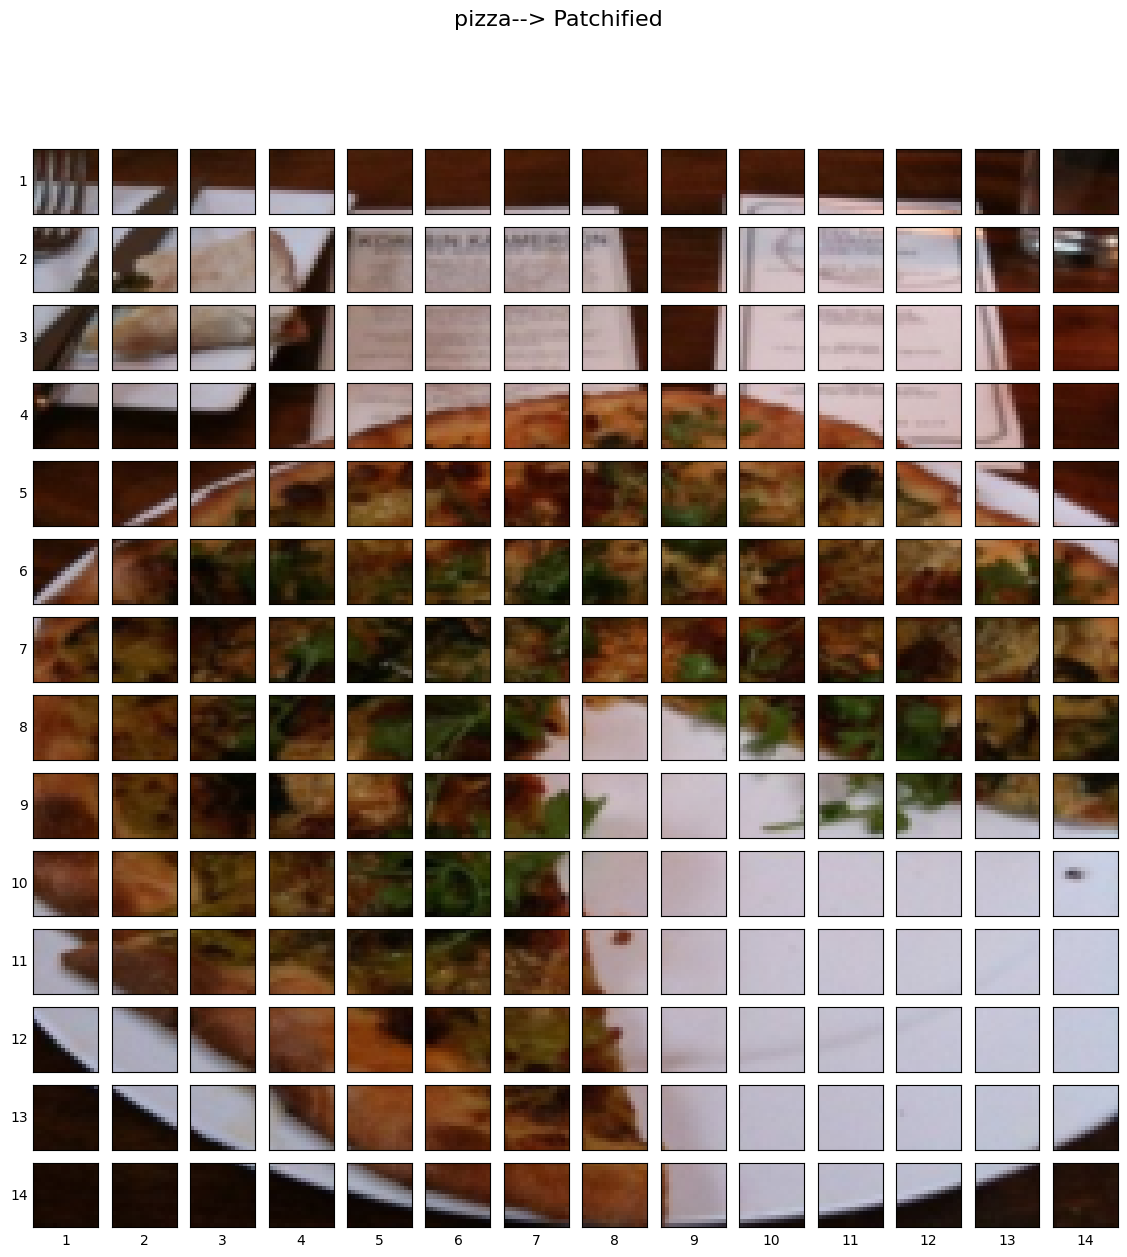

In [18]:
img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size%patch_size==0
print(f" Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches*num_patches}\
\nPatch_size: {patch_size} pixels x {patch_size} pixels")

fig, axs=plt.subplots(nrows=img_size//patch_size,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):

    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                 patch_width: patch_width+patch_size,
                                 :])
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment='right',
                        verticalalignment='center')
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

fig.suptitle(f"{class_names[label]}--> Patchified", fontsize=16)
plt.show()

* 시도해본 결과 하나의 이미지가 패치별로 나눠진 것을 확인할 수 있다.

## 4.3 Creating image patches with `torch.nn.Conv2d()`
* 사실 우리가 시도한 패치 임베딩은 convolutional block을 통해 시도할 수도 있다.
* kernel_size와 stride를 각각 patch_size와 동일하게 한다면 패치 임베딩의 효과를 얻을 수 있다.


In [19]:
from torch import nn
patch_size=16
conv2d=nn.Conv2d(in_channels=3,
                 out_channels=768,
                 kernel_size=patch_size,
                 stride=patch_size,
                 padding=0)

(-0.5, 223.5, 223.5, -0.5)

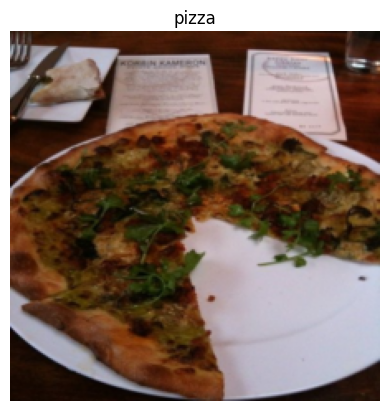

In [20]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [21]:
image_out_of_conv=conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


* 이는 [batch_size, embedding_dim, feature_map_height, feature_map_width]에 해당된다.

* 이제 다섯 개의 랜덤한 특성 맵을 살펴보자.

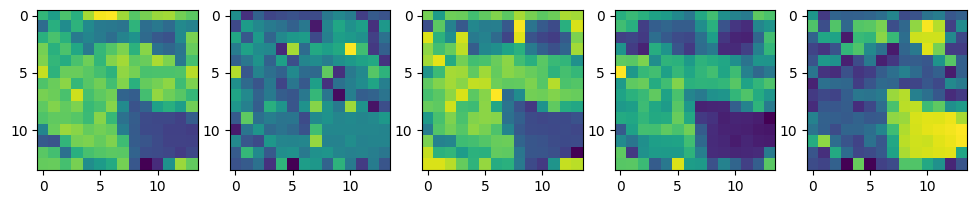

In [22]:
import random
random_indexes=random.sample(range(0,758), k=5)
fig, axs=plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
  image_conv_feature_map=image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())

Showing random convolutional feature maps from indexes: [436, 339, 736, 349, 378]


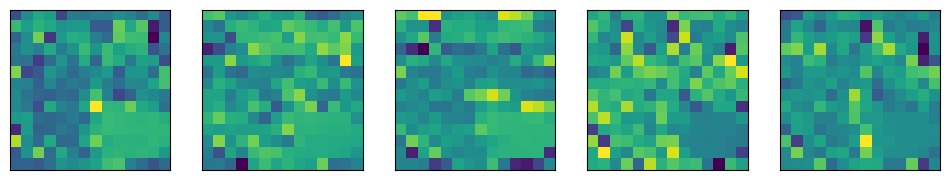

In [23]:
import random
random_indexes=random.sample(range(0,758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs=plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
  image_conv_feature_map=image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

* 이러한 특성 맵은 모델이 학습하는 과정을 거치면서 변화할 수 있다.
* 이러한 특성에 기반하여 학습 가능한 임베딩으로 사용될 수 있다.

## 4.4 Flattening the patch embedding with `torch.nn.Flatten()`
* 이제 1차원의 시퀀스로 만들기 위한 과정이다.

In [24]:
print(f"Current tensor shape: {image_out_of_conv.shape}")

Current tensor shape: torch.Size([1, 768, 14, 14])


In [25]:
flatten=nn.Flatten(start_dim=2,
                   end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


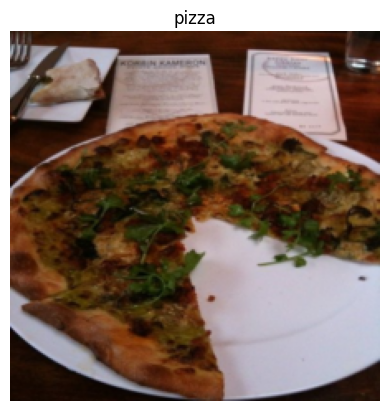

In [26]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

image_out_of_conv=conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened=flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

* 우리가 원하는 형태로 이미지 데이터가 변환된 것을 확인할 수 있다.
* [1x768x196]
* 다만 순서만을 제대로 바꿔주면 된다.

In [27]:
image_out_of_conv_flattened_reshaped=image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


* 우리가 학습할 수 있는 형태의 기본 이미지 데이터 형태가 완성된 것을 확인할 수 있다.

(-0.5, 195.5, 0.5, -0.5)

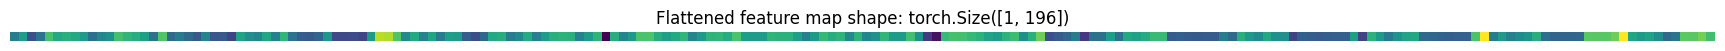

In [28]:
single_flattened_feature_map=image_out_of_conv_flattened_reshaped[:,:,0]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

* 이를 시각화 해보면 위와 같이 나온다.

In [29]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
    super().__init__()
    self.patch_size=patch_size
    self.patcher=nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)
    self.flatten=nn.Flatten(start_dim=2,
                            end_dim=3)

  def forward(self, x):
    image_resolution=x.shape[-1]
    assert image_resolution%self.patch_size

    x_patched=self.patcher(x)
    x_flatten=self.flatten(x_patched)
    return x_flatten.permute(0,2,1)

## 4.5 Turning the ViT patch embedding layer into PyTorch module
* 이제 임베딩 관련한 연습은 끝났고 지금까지 연습한 것들을 총 집합해 patch embedding 레이어를 만들어 보도록 하겠다.

In [30]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
    super().__init__()
    self.patch_size=patch_size

    self.patcher=nn.Conv2d(in_channels=in_channels,
                         out_channels=embedding_dim,
                         kernel_size=patch_size,
                         stride=patch_size,
                         padding=0)
    self.flatten=nn.Flatten(start_dim=2,
                          end_dim=3)



  def forward(self, x):
    # input이 알맞은 형태인지 assert를 통해 확인한다.
    image_resolution=x.shape[-1]
    assert image_resolution % self.patch_size==0

    x_patched=self.patcher(x)
    x_flattened=self.flatten(x_patched)

    return x_flattened.permute(0,2,1)

* 위에서 설정한 레이어가 잘 작동하는지 확인하기 위해 하나의 이미지로 체크해본다.

In [31]:
set_seeds()
patchify=PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image=patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


* 우리가 설정한 PatchEmbedding class가 잘 작동하는 것을 확인할 수 있다.

In [32]:
patch_embedding=PatchEmbedding(patch_size=16)
patch_embedding_output=patch_embedding(rand_image_tensor)
print(f"input shape: {rand_image_tensor.shape}")
print(f"output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

input shape: torch.Size([32, 3, 224, 224])
output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


* 랜덤 이미지를 설정하여 확인해보아도 알맞은 형태로 내뱉는 것을 확인할 수 있다.

## 4.6 Creating the class token embedding
* 이제 논문에서 나왔던 $X_{class}$를 설정해보도록 하겠다.

In [33]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape}")

tensor([[[-0.4538,  0.0044, -0.1579,  ...,  0.2377, -0.0273,  0.3155],
         [-0.1378, -0.0662, -0.2855,  ...,  0.1839,  0.0840,  0.2458],
         [-0.2645,  0.0672, -0.3799,  ...,  0.4122,  0.0462,  0.1040],
         ...,
         [-0.5216,  0.1860,  0.3015,  ...,  0.2605, -0.4780,  0.0553],
         [-0.0060, -0.1257, -0.0054,  ...,  0.2425, -0.3258,  0.0482],
         [-0.1222, -0.0038, -0.0433,  ...,  0.0696, -0.0452,  0.0572]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768])


In [34]:
batch_size=patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]

class_token=nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                         requires_grad=True)
print(class_token[:,:,:10])
print(f"class token shape: {class_token.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class token shape: torch.Size([1, 1, 768])


* `class` 토큰을 생성하여 패치 임베딩된 데이터에 더해준다.
* 토큰을 더해줌으로써, 중간에 number_of_patches가 197로 1증가한 것을 알 수 있다.

In [35]:
patch_embedded_image_with_class_embedding=torch.cat((class_token, patch_embedded_image),
                                                    dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4538,  0.0044, -0.1579,  ...,  0.2377, -0.0273,  0.3155],
         [-0.1378, -0.0662, -0.2855,  ...,  0.1839,  0.0840,  0.2458],
         ...,
         [-0.5216,  0.1860,  0.3015,  ...,  0.2605, -0.4780,  0.0553],
         [-0.0060, -0.1257, -0.0054,  ...,  0.2425, -0.3258,  0.0482],
         [-0.1222, -0.0038, -0.0433,  ...,  0.0696, -0.0452,  0.0572]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])


## 4.7 Creating the position embedding
* 이제 위치 임베딩을 고려해야 할 차례이다.

In [36]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4538,  0.0044, -0.1579,  ...,  0.2377, -0.0273,  0.3155],
          [-0.1378, -0.0662, -0.2855,  ...,  0.1839,  0.0840,  0.2458],
          ...,
          [-0.5216,  0.1860,  0.3015,  ...,  0.2605, -0.4780,  0.0553],
          [-0.0060, -0.1257, -0.0054,  ...,  0.2425, -0.3258,  0.0482],
          [-0.1222, -0.0038, -0.0433,  ...,  0.0696, -0.0452,  0.0572]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [37]:
torch.ones(1, number_of_patches+1, embedding_dimension).shape

torch.Size([1, 197, 768])

In [38]:
number_of_patches=int((224*224)/patch_size**2)
embedding_dimension=patch_embedded_image_with_class_embedding.shape[2]

position_embedding=nn.Parameter(torch.ones(1,
                                           number_of_patches+1,
                                           embedding_dimension),
                                requires_grad=True)

print(position_embedding[:,:10, :10])
print(f"Position embedding shape: {position_embedding.shape}")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768])


* position embedding도 알맞은 사이즈로 형성된 것을 확인할 수 있다.

In [39]:
patch_and_position_embedding=patch_embedded_image_with_class_embedding+position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5462, 1.0044, 0.8421,  ..., 1.2377, 0.9727, 1.3155],
         [0.8622, 0.9338, 0.7145,  ..., 1.1839, 1.0840, 1.2458],
         ...,
         [0.4784, 1.1860, 1.3015,  ..., 1.2605, 0.5220, 1.0553],
         [0.9940, 0.8743, 0.9946,  ..., 1.2425, 0.6742, 1.0482],
         [0.8778, 0.9962, 0.9567,  ..., 1.0696, 0.9548, 1.0572]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768])


* 마지막으로 해당 위치 임베딩과 class토큰이 고려된 패치 임베딩을 더해준다.
* 이로써 Vision Transformer의 Input 형성이 완료되었다.


## 4.8 Putting it all together: from image to embedding
* 지금까지 한 내용을 최종적으로 정리해보면 다음과 같다.
1. 먼저 패치의 크기를 정한다.
2. 이미지 데이터의 shape을 살펴보고 height과 width를 저장한다.
3. batch dimension을 이미지 데이터에 추가한다.
4. 설정한 패치 크기를 바탕으로 PatchEmbedding layer를 만든다.
5. 해당 레이어에 이미지 데이터를 통과시켜 패치 임배딩의 시퀀스 형태로 만든다.
6. class 토큰을 생성한다.
7. class 토큰 임베딩을 패치 임베딩 앞에 놓는다.
8. 위치 임베딩을 생성한다.
9. 기존의 임베딩에 위치 임베딩을 더한다.

In [40]:
set_seeds()

# 1.패치크기를 결정한다.
patch_size = 16

# 2. 기존 이미지 데이터의 shape을 확인하고 height, width을 저장해준다.
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. 이미지 텐서에 batch_dimension을 추가해준다.
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4.PatchEmbedding layer를 만들어준다.
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. 이미지 데이터를 패치 임베딩 레이어에 통과시킨다.
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. class 토큰을 생성한다.
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. class 토큰을 패치 임베딩 앞에 오도록 설정한다.
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. 위치 임베딩을 생성한다.
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. 위치 임베딩과 이전의 임베딩을 더해줌으로써 마무리된다.
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 5. Equation 2: Multi-Head Attention(MSA)
* Multi-Head Self Attention(MSA)는 `torch.nn.MultiheadAttention()`으로 실행할 수 있다.
* 정규화 과정인 Norm(LN or LayerNorm)은 `torch.nn.LayerNorm()` 코드로 실행 가능하다.


## 5.1 The Layer Norm(LN) layer
* 레이어 정규화 과정은 학습 시간을 줄여주고 모델의 일반화에도 도움이 된다.


## 5.2 The Multi-Head Self Attention (MSA) layer
* ViT에서의 MSA는 특정한 이미지 패치가 다른 패치들 중 어떤 패치와 관련성이 높은지 계산을 함으로써 궁극적으로는 전체 이미지의 표현을 학습하게 된다.
* `torch.nn.MultiheadAttention()`에는 네 가지 하이퍼 파라미터가 존재한다.
* `embed_dim`: 임베딩의 차원
* `num_heads`: 어텐션 헤드들의 개수.
* `dropout`: 어텐션 레이어에 dropout을 적용할 비율
* `batch_first`: 데이터 shape에서 배치 차원이 먼저 오는가?


##5.3 Replicating Equation 2 with Pytorch layers
1. 먼저 `torch.nn.Module`로부터 상속받아 `MultiheadSelfAttentionBlock`을 생성한다.
2. ViT 논문에서 나온대로 하이퍼파라미터를 설정해 ViT-Base 모델 개발을 시작한다.
3. 레이어 정규화 과정을 `torch.nn.LayerNorm()`으로 시작한다. 여기서 `normalized_shape`은 임베딩 차원과 동일시 한다.
4. `embed_dim`, `num_heads`,  `dropout`, `batch_first`에 적당한 값을 사용하여 multi-head attention layer을 생성한다.
5. 마지막으로 `forward()` 매소드를 사용하여 LN layer와 MSA layer에 통과시킨다.

In [41]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:float=0):
    super().__init__()

    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,
                                              num_heads=num_heads,
                                              dropout=attn_dropout,
                                              batch_first=True)

  def forward(self, x):
    x=self.layer_norm(x)
    attn_output,_=self.multihead_attn(query=x,
                                      key=x,
                                      value=x,
                                      need_weights=False)

    return attn_output


* 생성한 위 MultiheadSelfAttentionBlock을 위에서 생성한 `patch_and_position_embedding`을 통과시켜 보도록 하자.

In [42]:
multi_head=MultiheadSelfAttentionBlock(embedding_dim=768,
                                       num_heads=12)
multi_head(patch_and_position_embedding).shape

torch.Size([1, 197, 768])

In [43]:
multihead_self_attention_block=MultiheadSelfAttentionBlock(embedding_dim=768,
                                                           num_heads=12)

patched_image_through_msa_block=multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


* 데이터의 shape은 변함이 없지만 안에 있는 값들은 변화했을 것이다.

In [44]:
patch_and_position_embedding==patched_image_through_msa_block

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

#6. Equation 3: Multilayer Perceptron(MLP)
* 이 방정식에서도 앞서 보았지만 MLP를 통과하기 이전에 정규화 레이어를 먼저 통과한다.
* MLP는 ViT논문에서는 2개의 선형 레이어 `torch.nn.Linear()`을 사용했고 활성화함수로는 gelu함수를 사용했다. 이는 `torch.nn.GELU()`를 사용하면 된다.
* 또한 모든 선형 레이어에는 dopout layer가 존재한다. 비율은 0.1이 된다.
* 최종적인 MLP의 과정은 다음과 같을 것이다.
* layer_norm -> linear layer -> non-linear layer-> dropout -> linear layer -> dropout

In [45]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp=nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x=self.layer_norm(x)
    x=self.mlp(x)

    return x

* 다음으로 앞서 만들었던 `patched_image_through_msa_block`을 `MLPBlock`에 통과시켜 보도록 하겠다.

In [46]:
mlp_block=MLPBlock(embedding_dim=768,
                   mlp_size=3072,
                   dropout=0.1)
patched_image_through_mlp_block=mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


* 이번에도 데이터의 shape은 변화되지 않은 것을 확인할 수 있었다.

#7. Creating the Transformer Encoder
* 이제 만든 `MultiheadSelfAttentionBlock`과 `MLPBlock`을 이용해서 Transformer Encoder를 생성할 수 있다.
* 다만 이제는 residual learning인 잔여학습에 대한 고려를 해야한다.


##7.1 Creating a Transformer Encoder by combining our custom mad layers
1. 먼저 `TransformerEncoderBlock`을 `torch.nn.Module`로부터 상속받아 생성한다.
2. ViT 논문에서 ViT-base모델에 있는 하이퍼파라미터를 바탕으로 class를 시작한다.
3. MSA블럭을 `MultiheadSelfAttentionBlock`에 적당한 하이퍼파라미터로 생성한다.
4. MLP블럭을 `MLPBlock`에 적당한 하이퍼파라미터로 생성한다.
5. `forward()`매소드로 `TransformerEncoderBlock`클래스를 생성한다.
6. 이제 MSA block을 잔여학습으로 연결한다.
7. MLP 블럭을 잔여학습으로 연결한다.

In [47]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):
    super().__init__()

    self.msa_block=MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                               num_heads=num_heads,
                                               attn_dropout=attn_dropout)

    self.mlp_block=MLPBlock(embedding_dim=embedding_dim,
                            mlp_size=mlp_size,
                            dropout=mlp_dropout)

  def forward(self, x):
    x=self.msa_block(x)+x
    x=self.mlp_block(x)+x

    return x

* 트랜스포머 인코더 블럭이 완성되었는데 이 블럭을 총 12개를 쌓는 구조를 시도한다.
* 그 전에 먼저 `torchinfo.summary()`를 사용하여 (1,197,768)의 input을 트랜스포머 인코더 블럭을 통과시킨 결과를 확인해본다.

In [48]:
transformer_encoder_block=TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

* 학습되어야 할 총 파라미터는 708만 7872개가 된다.

## 7.2 Creating a Transformer Encoder with Pytorch's Transformer layers
* 다음의 과정은 pytorch에 내장된 트랜스포머 인코더 블럭의 내용이다.

In [49]:
transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=768,
                                                     nhead=12,
                                                     dim_feedforward=3072,
                                                     dropout=0.1,
                                                     activation="gelu",
                                                     batch_first=True,
                                                     norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [50]:
from torchinfo import summary
summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

In [51]:
transformer_encoder=nn.TransformerEncoder(encoder_layer=transformer_encoder_layer,
                                          num_layers=12)

In [52]:
summary(model=transformer_encoder,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-3      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-4      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-5      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-6      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-7      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-8      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-9      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-10     [32, 196, 768]            7,087,872
│    └─Transfor

#8. Putting it all together to create ViT
* 이제 최종적인 ViT class를 생성한다.

In [53]:
# 1. nn.Module로부터 상속받은 nn.Module을 생성한다.
class ViT(nn.Module):
  # 2. 논문에서 나온 수치 그대로를 적용하여 하이퍼파라미터를 적용한다.
  def __init__(self,
              img_size:int=224,
              in_channels:int=3,
              patch_size:int=16,
              embedding_dim:int=768,
              mlp_size:int=3072,
              num_transformer_layers:int=12,
              num_heads:int=12,
              atten_dropout:float=0,
              mlp_dropout:float=0.1,
              embedding_dropout:float=0.1,
              num_classes:int=1000):
    super().__init__()

    # 3. 이미지의 사이즈를 패치 사이즈별로 나눌 수 있게 해준다.
    assert img_size % patch_size==0
    # 4. 패치들의 사이즈를 계산한다.
    self.num_patches=(img_size*img_size)//patch_size**2
    # 5. class embedding을 생성한다.
    self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim), requires_grad=True)
    # 6. 그 다음으로 위치 임베딩을 생성한다.
    self.position_embedding=nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                         requires_grad=True)
    # 7. 임베딩 dropout 값을 생성한다.
    self.embedding_dropout=nn.Dropout(p=embedding_dropout)

    # 8. 패치 임베딩 레이어를 생성한다.
    self.patch_embedding=PatchEmbedding(in_channels=in_channels,
                                        patch_size=patch_size,
                                        embedding_dim=embedding_dim)
    # 9. 이제 transfomer 인코더 블럭의 스택 형식으로 transformer인코더를 생성한다.
    self.transformer_encoder=nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                     num_heads=num_heads,
                                                                     mlp_size=mlp_size,
                                                                     mlp_dropout=mlp_dropout)])
    # 10. 분류를 위해 classifier를 생성한다.
    self.classifier=nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  # 11. 차례대로 forward 매소드를 사용하여 각각의 레이어를 통과시킨다.
  def forward(self, x):
    # 12. 먼저 배치 사이즈를 얻는다.
    batch_size=x.shape[0]

    # 13. 클래스 토큰 임베딩을 생성하고 이를 배치 사이즈와 맞춘다.
    class_token=self.class_embedding.expand(batch_size, -1, -1)
    # 14. 패치 임베딩을 생성한다.
    x=self.patch_embedding(x)
    # 15. 클래스 토큰과 패치 임배딩을 결합한다.
    x=torch.cat((class_token, x), dim=1)
    # 16. 거기에 포지션 임베딩을 더해주고 잔여학습을 위해 이전의 것을 더해준다.
    x=self.position_embedding + x
    # 17. dropout을 사용한다.
    x=self.embedding_dropout(x)
    #18. transformer encoder에 나머지를 통과시킨다.
    x=self.transformer_encoder(x)
    #19. 다층 퍼셉트론에 통과시킨다.
    x=self.classifier(x[:,0])

    return x

In [54]:
batch_size=32
class_token_embedding_single=nn.Parameter(data=torch.randn(1,1,768))
class_token_embedding_expanded=class_token_embedding_single.expand(batch_size, -1,-1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [55]:
# 랜덤 텐서를 똑같은 shape으로 생성한다.
demo_img=torch.randn(1,3,224,224)
print(demo_img.shape)
# 이를 vit에 넣어서 계산을 해본다.
vit=ViT(num_classes=len(class_names))
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[-0.3941, -0.5887, -0.6498]], grad_fn=<AddmmBackward0>)

## 8.1 Getting a visual summary of our ViT model
* 우리가 생성한 vision transformer 모델에 대한 summary를 시각화해 보자.

In [56]:
from torchinfo import summary
summary(model=vit,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

* 총 783만 4371개의 파라미터를 학습시켜야 하는 것을 확인할 수 있다.

# 9. Setting up training code for our ViT model
* 이제 모델을 학습 시킬 시간이다.

In [57]:
from going_modular.going_modular import engine
optimizer=torch.optim.Adam(params=vit.parameters(),
                           lr=3e-3)

loss_fn=torch.nn.CrossEntropyLoss()
set_seeds()

results=engine.train(model=vit,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=10,
                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1158 | train_acc: 0.3644 | test_loss: 8.6859 | test_acc: 0.4133
Epoch: 2 | train_loss: 9.0859 | train_acc: 0.3200 | test_loss: 11.7575 | test_acc: 0.2533
Epoch: 3 | train_loss: 9.9789 | train_acc: 0.3333 | test_loss: 6.6740 | test_acc: 0.3333
Epoch: 4 | train_loss: 5.4246 | train_acc: 0.3467 | test_loss: 5.1859 | test_acc: 0.2533
Epoch: 5 | train_loss: 4.1825 | train_acc: 0.3333 | test_loss: 3.0237 | test_acc: 0.2533
Epoch: 6 | train_loss: 2.4269 | train_acc: 0.3333 | test_loss: 2.1653 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.9401 | train_acc: 0.3467 | test_loss: 1.4652 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.5319 | train_acc: 0.3467 | test_loss: 1.6029 | test_acc: 0.4133
Epoch: 9 | train_loss: 1.8414 | train_acc: 0.3200 | test_loss: 1.9558 | test_acc: 0.4133
Epoch: 10 | train_loss: 2.2058 | train_acc: 0.3200 | test_loss: 1.8206 | test_acc: 0.4133


## 9.1 What our training setup is missing
* 위의 결과를 보면 알 수 있듯이, 우리 모델의 성능은 그렇게 좋지 않았다.
* 이는 논문의 내용과 비교해보았을 때, 우리의 데이터의 사이즈가 현저히 적고 learning rate warmup과 learning rate decay, gradient clipping과 같은 하이퍼파라미터를 고려하지 않았기 때문일 수도 있다.
* 따라서 pretrained 된 모델들을 가지고 우리의 데이터로 학습하는 방법이 있다.
* 일단 먼저 loss 그래프를 그려보자


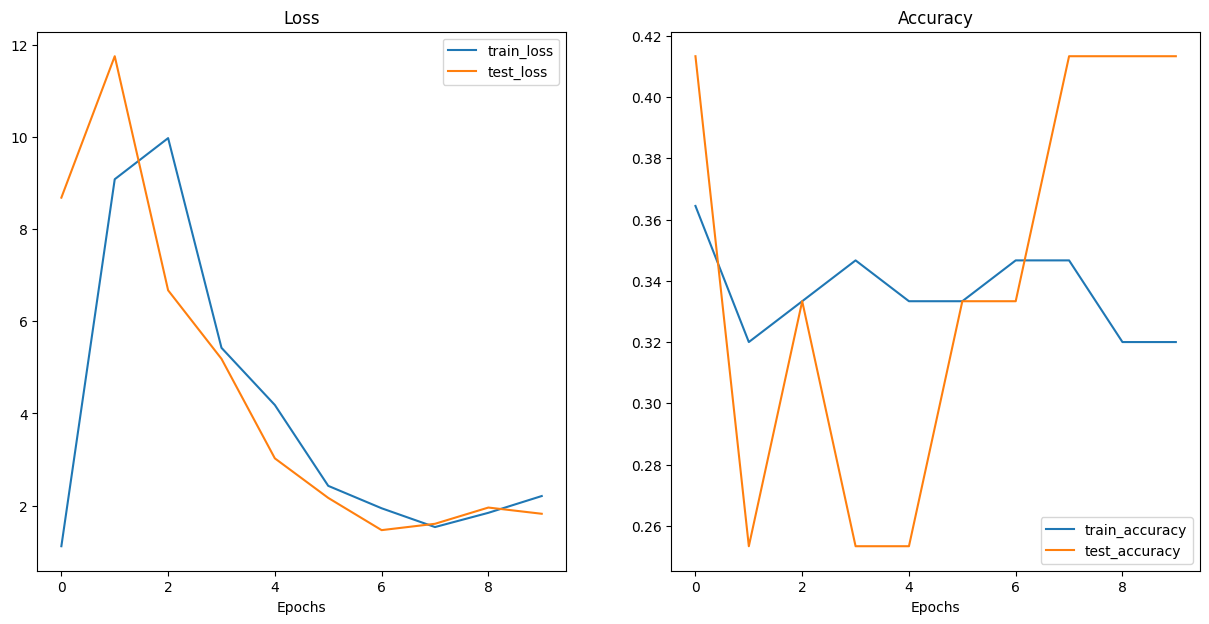

In [58]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

* loss가 전체적인 추세로는 감소하고 있지만, 여전히 뒤죽박죽으로 튀는 것을 알 수 있다.
* pretrained 모델을 가지고 학습을 시켜보도록 하자.

# 10. Getting a pretrained ViT model and creating a feature extractor

* 먼저 ViT-Base 모델의 사전 학습된 weight들을 가지고 와본다.
* 사전 학습된 모델을 가지고 ViT모델을 생성한다.
* Base 모델의 파라미터를 freeze 시킨다.
* Classifier head를 바꾼다.

In [59]:
import torchvision
vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit=torchvision.models.vit_b_16(weights=vit_weights)

for param in pretrained_vit.parameters():
  param.requires_grad=False

embedding_dim=768
set_seeds()

pretrained_vit.heads=nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 93.7MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

* ViT-Base모델의 사전학습으로 ImageNet-1k로부터 `torchvision.models.ViT_B_16_Weights.DEFAULT`로 가중치를 가져온다.
* `torchvision.models.vit_b_16`을 통해 ViT모델을 setup 한다.
* 그리고 파라미터들을 freeze 시킨다.
* 모델의 전체적인 구조에 대해서 확인해보자.

* 총 파라미터의 개수는 8580만 2499개이지만, 학습가능한 파라미터는 3843개 정도 밖에 되지 않는다.

## 10.3 Preparing data for the pretrained ViT model


In [61]:
pretrained_vit_transforms=vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


우리의 이미지 데이터들을 데이터 로더로 바꾼다.

In [62]:
train_dir=image_path/"train"
test_dir=image_path/"test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [63]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=pretrained_vit_transforms,
                                                                                                   batch_size=1024)

## 10.4 Train feature extractor ViT model
* 이제 모델을 학습시켜보도록 한다.

In [64]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=pretrained_vit.parameters(),
                           lr=1e-3)
loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results=engine.train(model=pretrained_vit,
                                         train_dataloader=train_dataloader_pretrained,
                                         test_dataloader=test_dataloader_pretrained,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=10,
                                         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1996 | train_acc: 0.2356 | test_loss: 1.0288 | test_acc: 0.4933
Epoch: 2 | train_loss: 0.9540 | train_acc: 0.5200 | test_loss: 0.8233 | test_acc: 0.6267
Epoch: 3 | train_loss: 0.7645 | train_acc: 0.7244 | test_loss: 0.6687 | test_acc: 0.7067
Epoch: 4 | train_loss: 0.6205 | train_acc: 0.8178 | test_loss: 0.5519 | test_acc: 0.8133
Epoch: 5 | train_loss: 0.5113 | train_acc: 0.8667 | test_loss: 0.4629 | test_acc: 0.8800
Epoch: 6 | train_loss: 0.4283 | train_acc: 0.8978 | test_loss: 0.3951 | test_acc: 0.8933
Epoch: 7 | train_loss: 0.3649 | train_acc: 0.9156 | test_loss: 0.3435 | test_acc: 0.9067
Epoch: 8 | train_loss: 0.3161 | train_acc: 0.9289 | test_loss: 0.3042 | test_acc: 0.9067
Epoch: 9 | train_loss: 0.2781 | train_acc: 0.9378 | test_loss: 0.2742 | test_acc: 0.8933
Epoch: 10 | train_loss: 0.2481 | train_acc: 0.9378 | test_loss: 0.2514 | test_acc: 0.9200


In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

## 10.6 Save feature extractor ViT model and check file size

In [65]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [66]:
from pathlib import Path
pretrained_vit_model_size=Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size//(1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# 11. Make predictinos on a custom image

In [67]:
import requests
from going_modular.going_modular.predictions import pred_and_plot_image
custom_image_path=image_path/"04-pizza-dad.jpeg"

image_dir="data/pizza_steak_sushi/test/sushi"
Path(image_dir).mkdir(parents=True, exist_ok=True)
image_filename="04-pizza-dad.jpeg"
custom_image_path=Path(image_dir)/image_filename

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)

else:
  print(f"{custom_image_path} already exists, skipping download...")

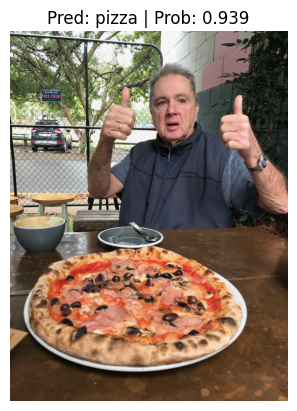

In [68]:
  pred_and_plot_image(model=pretrained_vit,
                      image_path=custom_image_path,
                      class_names=class_names)

In [69]:
%%writefile vit.py
import torch
from torch import nn

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

Writing vit.py


In [70]:
!python vit.py

In [71]:
from vit import ViT
imported_vit=ViT()
summary(model=imported_vit,
        input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 1000]                 152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [72]:
set_seeds()

In [73]:
import torchvision
vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit=torchvision.models.vit_b_16(weights=vit_weights)

for param in pretrained_vit.parameters():
  param.requires_grad=False

embedding_dim=768
set_seeds()

pretrained_vit.heads=nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

summary(model=pretrained_vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [74]:
data_20_percent_path=download_data(source=" https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                   destination="pizza_steak_sushi_20_percent")

train_dir_20_percent=data_20_percent_path/"train"

vit_transforms=vit_weights.transforms()
train_dataloader_20_percent, test_dataloader, class_names=data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                       test_dir=test_dir,
                                                                                       batch_size=1024,
                                                                                       transform=vit_transforms)

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [75]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=pretrained_vit.parameters(),
                           lr=1e-3)
loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results=engine.train(model=pretrained_vit,
                                         train_dataloader=train_dataloader_20_percent,
                                         test_dataloader=test_dataloader,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=10,
                                         device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1996 | train_acc: 0.2356 | test_loss: 1.0288 | test_acc: 0.4933
Epoch: 2 | train_loss: 0.9540 | train_acc: 0.5200 | test_loss: 0.8233 | test_acc: 0.6267
Epoch: 3 | train_loss: 0.7645 | train_acc: 0.7244 | test_loss: 0.6687 | test_acc: 0.7067
Epoch: 4 | train_loss: 0.6205 | train_acc: 0.8178 | test_loss: 0.5519 | test_acc: 0.8133
Epoch: 5 | train_loss: 0.5113 | train_acc: 0.8667 | test_loss: 0.4629 | test_acc: 0.8800
Epoch: 6 | train_loss: 0.4283 | train_acc: 0.8978 | test_loss: 0.3951 | test_acc: 0.8933
Epoch: 7 | train_loss: 0.3649 | train_acc: 0.9156 | test_loss: 0.3435 | test_acc: 0.9067
Epoch: 8 | train_loss: 0.3161 | train_acc: 0.9289 | test_loss: 0.3042 | test_acc: 0.9067
Epoch: 9 | train_loss: 0.2781 | train_acc: 0.9378 | test_loss: 0.2742 | test_acc: 0.8933
Epoch: 10 | train_loss: 0.2481 | train_acc: 0.9378 | test_loss: 0.2514 | test_acc: 0.9200


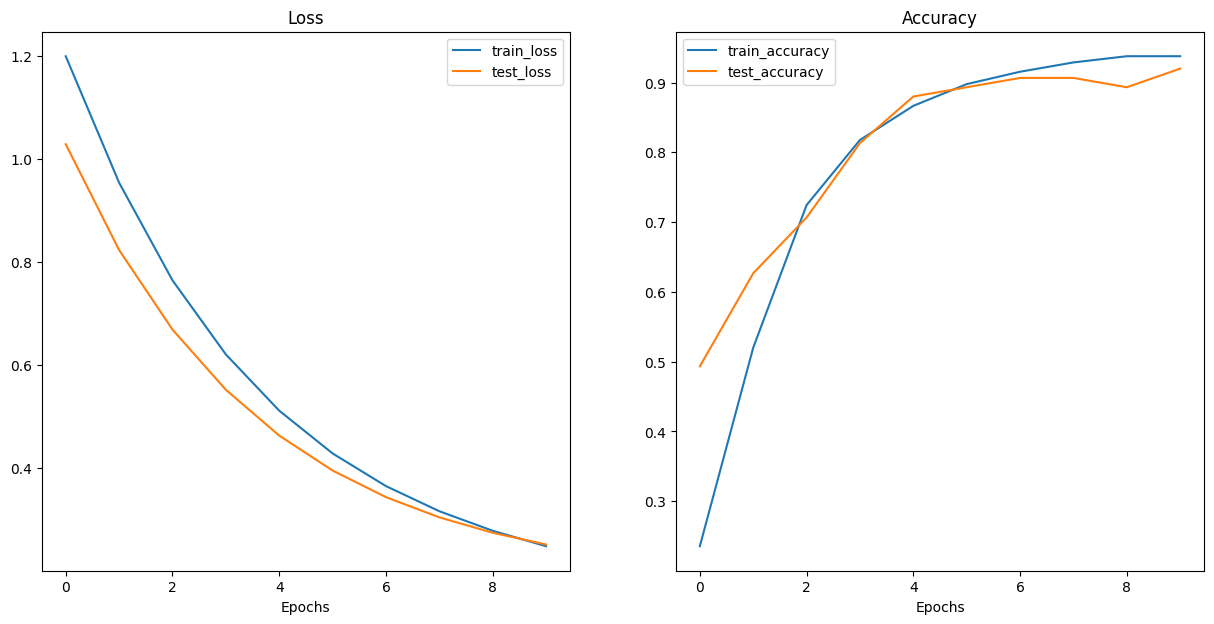

In [76]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [77]:
import torchvision
vit_weights_swag=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_vit_swag=torchvision.models.vit_b_16(weights=vit_weights_swag)

for param in pretrained_vit_swag.parameters():
  param.requires_grad=False

embedding_dim=768
set_seeds()
pretrained_vit_swag.heads=nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

summary(model=pretrained_vit_swag,
        input_size=(1,3,384,384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:05<00:00, 63.1MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [78]:
vit_transforms_swag=vit_weights_swag.transforms()
vit_transforms_swag

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [79]:
data_20_percent_path=download_data(source=" https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                   destination="pizza_steak_sushi_20_percent")

train_dir_20_percent=data_20_percent_path/"train"

vit_transforms=vit_weights_swag.transforms()
train_dataloader_20_percent, test_dataloader, class_names=data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                       test_dir=test_dir,
                                                                                       batch_size=1024,
                                                                                       transform=vit_transforms)

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [80]:
batch=next(iter(train_dataloader_20_percent))
batch2=next(iter(train_dataloader))
print(batch[0].shape)
print(batch2[0].shape)

torch.Size([450, 3, 384, 384])
torch.Size([225, 3, 224, 224])


In [1]:
from going_modular.going_modular import engine
optimizer=torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                           lr=1e-3)

loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results=engine.train(model=pretrained_vit_swag,
                                         train_dataloader=train_dataloader_20_percent,
                                         test_dataloader=test_dataloader,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=10,
                                         device=device)

NameError: ignored

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_swag_results)

In [ ]:
from tqdm import tqdm
from pathlib import Path
test_data_paths=list(Path(test_dir).glob('*/*.jpg'))
test_labels=[path.parent.stem for path in test_data_paths]

In [ ]:
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list=[]
  for path in tqdm(test_paths):
    pred_dict={}
    pred_dict['image_path']=path
    class_name=path.parent.stem
    pred_dict['class_name']=class_name

    from PIL import Image
    img=Image.open(path)
    transformed_image=transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      pred_logit=model(transformed_image.to(device))
      pred_prob=torch.softmax(pred_logit, dim=1)
      pred_label=torch.argmax(pred_prob, dim=1)
      pred_class=class_names[pred_label.cpu()]

      pred_dict['pred_prob']=pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict['pred_class']=pred_class

    pred_dict["correct"]=class_name==pred_class

    test_pred_list.append(pred_dict)
  return test_pred_list

test_pred_dicts=pred_and_store(test_paths=test_data_paths,
                               model=pretrained_vit_swag,
                               transform=vit_transforms_swag,
                               class_names=class_names,
                               device=device)

test_pred_dicts[:5]

In [ ]:
import pandas as pd
test_pred_df=pd.DataFrame(test_pred_dicts)

top_5_most_wrong=test_pred_df.sort_values(by=["correct", 'pred_prob'], ascending=[True, False])
top_5_most_wrong

In [ ]:
test_pred_df.correct.value_counts()

In [ ]:
import torchvision
import matplotlib.pyplot as plt

for row in top_5_most_wrong.iterrows():
  row=row[1]
  image_path=row[0]
  true_label=row[1]
  pred_prob=row[2]
  pred_class=row[3]

  img=torchvision.io.read_image(str(image_path))

  plt.figure()
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob: .3f}")
  plt.axis(False)